Краткое описание произошедшего:
Обработал слова, удалил цифры, применил стемминг. Сначала попробовал предложенный метод MiniBatchKMeans, у него есть параметр n_clusters. Я почитал как его оптимизровать и нашел Silhouette_score, применил его, получил график, на котором видно что оптимальным значением будет 6 и оно дает отличный скор, около 0.90 (ничего из этого в коде не осталось). Далее начал визуализировать данные и увидел, что кластеров на самом деле скорее 5, чем 6. Попробовал TSNE и UMAP, оказалось, что кластеров и правда 5. Теперь осталось подобрать нужный метод кластеризации, нужен такой, в котором эксплицитно указывается количество кластеров. Попробовал GaussianMixture и это оказалось точное попадание, как видно на картинках.

Из идей было еще:
1) Разметить данные
2) Попробовать другие методы кластеризации

Но я уже получил отличный результат, поэтому остановился.

In [11]:
import nltk
import pandas as pd
import numpy as np
import scipy
import warnings
import string
import matplotlib.pyplot as plt

from umap import UMAP
from collections import defaultdict
from typing import List
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.mixture import GaussianMixture

nltk.download("stopwords")
warnings.filterwarnings("ignore")
RUSSIAN_STOPWORDS = list(stopwords.words("russian"))
stemmer = SnowballStemmer("russian")
rand_state = 46

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Mikhail\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


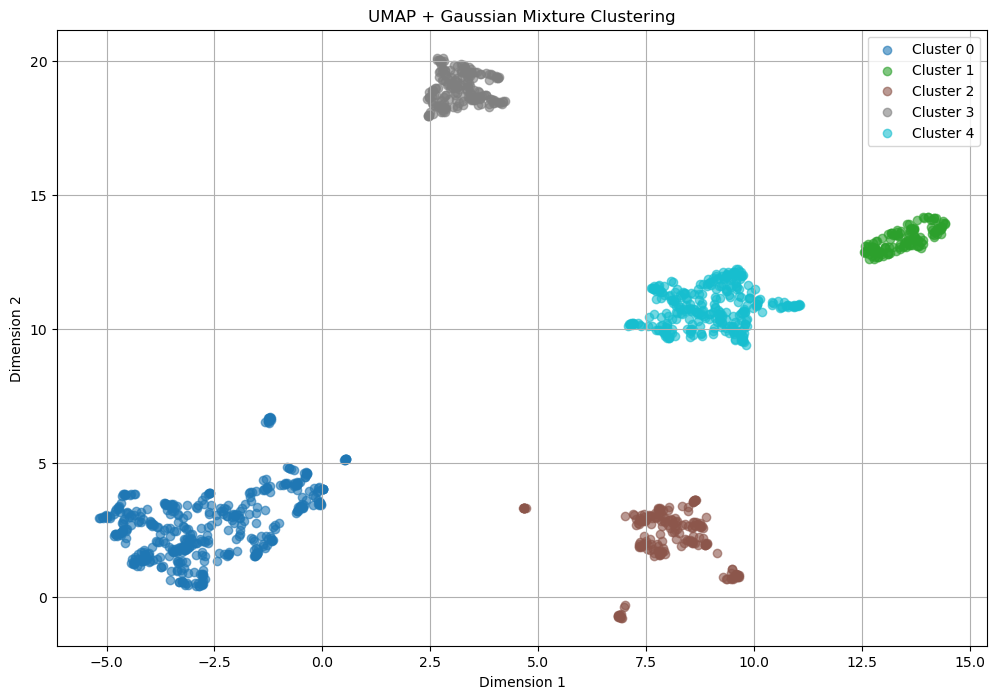

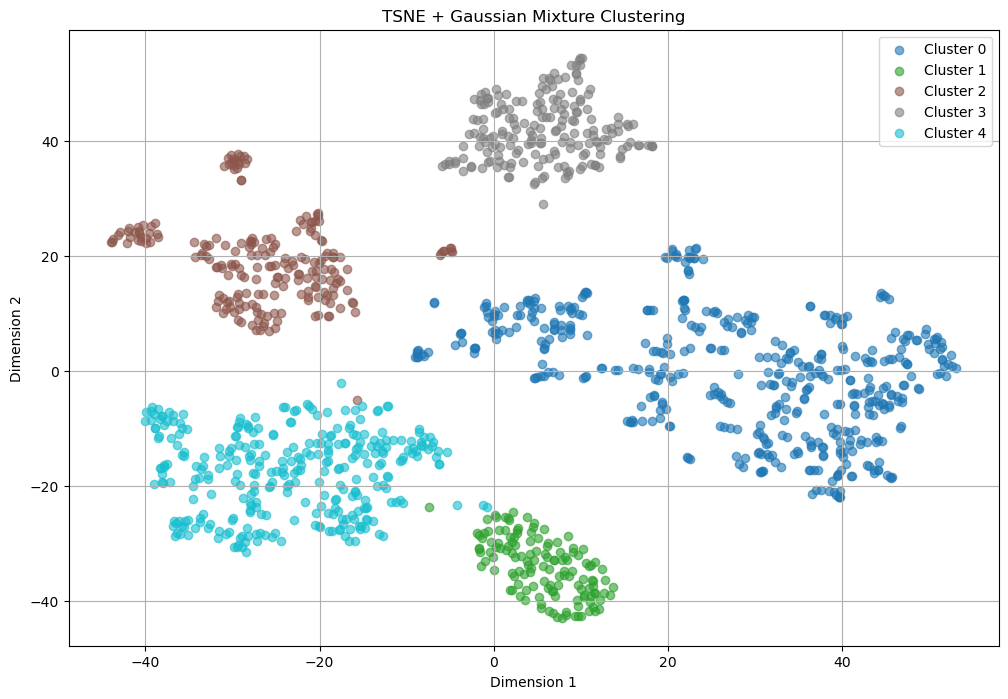

In [13]:
def process_text(text: str) -> List[str]:
    
    # Удалим знаки препинания и цифры. Цифр в тексте много, а знаков препинания я не видел, пусть будет на всякий случай.
    translator = str.maketrans('', '', string.punctuation + string.digits)
    text = text.translate(translator)
    
    tokens = text.split()
    
    # Удалим стоп-слова и применим стемминг
    processed_tokens = [stemmer.stem(token) for token in tokens if token not in RUSSIAN_STOPWORDS]
    
    return processed_tokens
    
class TextsPairClassifier(object):

    def __init__(self, data: List[str]):
        
        # Я попробовал CountVectorizer и TfidVectorizer, второй оказался лучше. Параметры более-менее стандартные.
        self.vectorizer = TfidfVectorizer(
            stop_words=RUSSIAN_STOPWORDS, 
            tokenizer=process_text, 
            ngram_range=(1,2), 
            max_df=0.90, 
            min_df=2
        )
        term_doc_matrix = self.vectorizer.fit_transform(data)
        
        # Понижение размерности. Попробовал TSNE, потом UMAP. UMAP дал очень четкую картинку, видно, что кластеров 5, осталось подобрать нужный метод кластеризации. 
        self.svd = TruncatedSVD(n_components=50, random_state= rand_state)
        term_doc_svd = self.svd.fit_transform(term_doc_matrix)
        
        self.umap = UMAP(n_components=2, random_state= rand_state)
        self.tsne = TSNE(n_components=2, perplexity=25, random_state= rand_state)
        term_doc_umap = self.umap.fit_transform(term_doc_svd)
        term_doc_TSNE = self.tsne.fit_transform(term_doc_svd)
        
        # Я попробовал MiniBatchKMeans и GaussianMixture, вторая дает лучшую картинку, идеальное попадание в 5 кластеров.
        self.clusterizer = GaussianMixture(n_components=5, covariance_type='full', random_state= rand_state)
        self.clusterizer.fit(term_doc_umap)
        self.labels_ = self.clusterizer.predict(term_doc_umap)
        
        # Вузуализируем. 
        self.plot_clusters(term_doc_umap, 'UMAP')
        self.plot_clusters(term_doc_TSNE, 'TSNE')
        
    def plot_clusters(self, reduced_data, model):
        plt.figure(figsize=(12, 8))
        unique_labels = set(self.labels_)
        colors = plt.cm.get_cmap('tab10', len(unique_labels))
        
        for label in unique_labels:
            color = colors(label)
            label_name = f'Cluster {label}'
            plt.scatter(
                reduced_data[self.labels_ == label, 0],
                reduced_data[self.labels_ == label, 1],
                c=[color],
                label=label_name,
                alpha=0.6
            )
        plt.legend()
        plt.title(model +  " + Gaussian Mixture Clustering")
        plt.xlabel("Dimension 1")
        plt.ylabel("Dimension 2")
        plt.grid(True)
        plt.show()

    def label(self, id1: int, id2: int):
        if self.labels_[id1] == self.labels_[id2]:
            return 1
        else:
            return 0
            
def generate_submission():
    texts = pd.read_csv("normalized_texts.csv", index_col="id", encoding="utf-8")
    pairs = pd.read_csv("pairs.csv", index_col="id")
    pairs = pairs-1     # Чтобы индексы совпадали

    classifier = TextsPairClassifier(texts["paragraph_lemmatized"].tolist())

    with open("submission.csv", "w", encoding="utf-8") as output:
        output.write("id,gold\n")
        for index, id1, id2 in pairs.itertuples():
            result = classifier.label(id1, id2)
            output.write(f"{index},{result}\n")

generate_submission()